In [1]:
#import fwiVis.fwiVis as fv
import s3fs
s3 = s3fs.S3FileSystem(anon=False)
from math import cos, asin, sqrt
import re

import numpy as np
import geopandas as gpd
import pandas as pd
from matplotlib import pyplot as plt
import os
import rioxarray as rio
import xarray as xr
import rasterio
import glob
from shapely.errors import ShapelyDeprecationWarning
from shapely.geometry import Point
import warnings
import folium
import datetime
import time
from folium import plugins
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 
import contextily as cx
from shapely.geometry import box
import sys
from datetime import datetime, timedelta

sys.path.insert(0, '/projects/old_shared/fire_weather_vis/base-fwi-vis/')
import fwiVis.fwiVis as fv

In [2]:
def concat_subsets(files):
    df = []
    for f in files:
        manyfr = pd.read_csv(f)

        manyfr = gpd.GeoDataFrame(manyfr)

        manyfr.t = manyfr.t.astype("datetime64[ns]")
        df.append(manyfr)
    df = pd.concat(df)
    return(df)

def get_lt(lt_string = "Lt_CA_Boreal_"):
    files = glob.glob("/projects/old_shared/fire_weather_vis/Lightning_analysis/computed_data/" + lt_string +"*.csv")
    return(concat_subsets(files))

In [3]:
lt = get_lt() # ~ 2.9 GB

In [4]:
prov = fv.ca_prov()

In [275]:
lt.columns

Index(['Unnamed: 0', 'InterCloud', 't', 'lat', 'lon', 'current_mag',
       'multiplicity_0', 'accr', 'error_elps', 'num_station', 'geometry'],
      dtype='object')

In [5]:
# lt = lt.sjoin(prov) # Too computationally expensive??
# lt

lt = gpd.GeoDataFrame(lt, geometry = gpd.points_from_xy(lt['lon'], lt['lat']), crs = "EPSG:4326")

In [6]:
#prov.crs

lt = lt.sjoin(prov) # Too computationally expensive??
lt

,Unnamed: 0,InterCloud,t,lat,lon,current_mag,multiplicity_0,accr,error_elps,num_station,geometry,index_right,prov_name_fr,prov_name_en
237,3778431,0,2023-09-29 17:31:51.050,48.131877,-90.376448,-4619.0,0,0.0,18.0,2.0,POINT (-90.37645 48.13188),9,Ontario,Ontario
238,3778452,0,2023-09-29 17:31:51.317,48.134854,-90.382519,-4074.0,0,0.0,12.0,2.0,POINT (-90.38252 48.13485),9,Ontario,Ontario
239,3734566,0,2023-09-29 17:21:06.021,48.142464,-90.503675,-65221.0,0,0.0,47.0,2.0,POINT (-90.50368 48.14246),9,Ontario,Ontario
240,3787132,0,2023-09-29 17:33:58.102,48.152815,-90.372594,-9300.0,0,0.0,33.0,1.0,POINT (-90.37259 48.15281),9,Ontario,Ontario
54275,3546061,0,2023-09-29 16:34:05.695,48.427381,-91.331994,-3566.0,0,0.0,7.0,1.0,POINT (-91.33199 48.42738),9,Ontario,Ontario
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14873,1468641,0,2023-08-14 03:58:28.213,46.898948,-64.021686,-8201.0,0,0.0,7.0,5.0,POINT (-64.02169 46.89895),6,Île-du-Prince-Édouard,Prince Edward Island
14879,1520434,0,2023-08-14 04:10:28.352,46.929660,-64.008065,-24468.0,0,0.0,10.0,3.0,POINT (-64.00807 46.92966),6,Île-du-Prince-Édouard,Prince Edward Island
14900,1317413,0,2023-08-14 03:25:01.148,46.896299,-64.119554,-8317.0,0,0.0,7.0,1.0,POINT (-64.11955 46.89630),6,Île-du-Prince-Édouard,Prince Edward Island
14902,1544268,0,2023-08-14 04:15:56.188,46.926400,-64.145600,-29161.0,0,0.0,6.0,4.0,POINT (-64.14560 46.92640),6,Île-du-Prince-Édouard,Prince Edward Island


In [6]:
snap = fv.prep_gdf(date = '20230501AM',layer='perimeter',handle_multi=False,only_lf=False,area_lim=5, year = "2023", path_region = "BOREAL_NRT_3571_DPS")

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


In [7]:
snap = snap.sjoin(prov)

In [99]:
test = snap[snap.duration == 0].groupby("prov_name_en").n_pixels.sum()
test.values

array([490, 232, 248,  45,  12,   1,   9,  42,   4,  48, 318,   1])

In [80]:
#iterables = [test.index, ['20230501AM']]

#pd.MultiIndex.from_product(iterables, names=["prov", "t"])

test = pd.DataFrame(test.values, columns=["farea"], index = test.index)
test.transpose()
#test["t"] = '20230501AM'

prov_name_en,Alberta,British Columbia,Manitoba,New Brunswick,Newfoundland and Labrador,Northwest Territories,Nova Scotia,Ontario,Prince Edward Island,Quebec,Saskatchewan,Yukon
farea,490,232,248,45,12,1,9,42,4,48,318,1


In [76]:
#test.t.astype("datetime64[ns]")


prov_name_en,Alberta,British Columbia,Manitoba,New Brunswick,Newfoundland and Labrador,Nova Scotia,Ontario,Prince Edward Island,Quebec,Saskatchewan,Yukon
farea,436,196,148,45,12,9,39,4,46,202,1
t,20230501AM,20230501AM,20230501AM,20230501AM,20230501AM,20230501AM,20230501AM,20230501AM,20230501AM,20230501AM,20230501AM


In [28]:
### To generate fire stats
date_range = pd.date_range(start = "2023-08-30 00:00:00", end = "2023-09-10 12:00:00", freq="12H")
#date_range_format = datetime.strptime(date_rage, 
date_snap = date_range.strftime("%Y%m%d%p")
date_snap
#nice_dates = date_range.strftime("%Y-%m-%d %p")

Index(['20230830AM', '20230830PM', '20230831AM', '20230831PM', '20230901AM',
       '20230901PM', '20230902AM', '20230902PM', '20230903AM', '20230903PM',
       '20230904AM', '20230904PM', '20230905AM', '20230905PM', '20230906AM',
       '20230906PM', '20230907AM', '20230907PM', '20230908AM', '20230908PM',
       '20230909AM', '20230909PM', '20230910AM', '20230910PM'],
      dtype='object')

In [17]:
### Figure out which lightning days failed at read-in. 


#all_dates = lt.t.dt.strftime("%Y-%m-%d").isin(date_range.strftime("%Y-%m-%d"))
#lt[~ all_dates].t.dt.strftime("%Y-%m-%d").unique()
print(min(lt.t))
date_range[~date_range.strftime("%Y-%m-%d").isin(lt.t.dt.strftime("%Y-%m-%d"))].strftime("%Y%m%d").unique()



2023-04-01 00:03:16.885000


Index([], dtype='object')

In [191]:
#snap["fireID"] = snap.index
ids = snap.groupby("prov_name_en").fireID.unique()

ids

iterables = [ date_range, ['Alberta', 'British Columbia', 'Manitoba', 'New Brunswick',
       'Newfoundland and Labrador', 'Nova Scotia',
       'Ontario', 'Prince Edward Island', 'Quebec', 'Northwest Territories', 'Saskatchewan', 'Yukon']]
index = pd.MultiIndex.from_product(iterables, names=["t", "prov"])

In [192]:
index

MultiIndex([('2023-05-01 12:00:00',                   'Alberta'),
            ('2023-05-01 12:00:00',          'British Columbia'),
            ('2023-05-01 12:00:00',                  'Manitoba'),
            ('2023-05-01 12:00:00',             'New Brunswick'),
            ('2023-05-01 12:00:00', 'Newfoundland and Labrador'),
            ('2023-05-01 12:00:00',               'Nova Scotia'),
            ('2023-05-01 12:00:00',                   'Ontario'),
            ('2023-05-01 12:00:00',      'Prince Edward Island'),
            ('2023-05-01 12:00:00',                    'Quebec'),
            ('2023-05-01 12:00:00',     'Northwest Territories'),
            ('2023-05-01 12:00:00',              'Saskatchewan'),
            ('2023-05-01 12:00:00',                     'Yukon'),
            ('2023-05-02 00:00:00',                   'Alberta'),
            ('2023-05-02 00:00:00',          'British Columbia'),
            ('2023-05-02 00:00:00',                  'Manitoba'),
          

In [30]:
from datetime import date
str(date.today().strftime("%Y%m%d"))

'20231030'

In [31]:
fire_stats = pd.DataFrame(data = [], columns=["prov_name_en", "t", "farea", "numfires", "num_active_fires",  "tot_frp", "mean_frp", "igs", "num_active_pixels", "fireID"])
snap_list = []
for d,n in zip(date_snap, range(0, len(date_range))):
    print(d)
    ## Read in 12 hour time point
    snap = fv.prep_gdf(date = d,layer='perimeter',handle_multi=False,only_lf=False,area_lim=5, year = "2023", path_region = "BOREAL_NRT_3571_DPS")
    snap["fireID"] = snap.index
    snap = snap.sjoin(prov)
    
    ## Get DF of province stats
    fireIDs = snap.groupby(["prov_name_en", "t"]).fireID.unique().reset_index()
    igs = snap[snap.duration == 0].groupby(["prov_name_en", "t"]).mergeid.count().reset_index()
    igs = igs.rename(columns={"mergeid":"igs"})
    
    num_active_pixels = snap[snap.duration == 0].groupby(["prov_name_en", "t"]).n_pixels.sum() + snap.groupby(["prov_name_en", "t"]).n_newpixels.sum()
    num_active_pixels = num_active_pixels.reset_index()
    num_active_pixels = num_active_pixels.rename(columns={0:"num_active_pixels"})
    
    farea = snap.groupby(["prov_name_en", "t"]).farea.sum().reset_index()
    numfires = snap.groupby(["prov_name_en", "t"]).mergeid.count().reset_index()
    numfires = numfires.rename(columns={"mergeid":"numfires"})
    
    tot_frp = snap.groupby(["prov_name_en", "t"]).meanFRP.sum().reset_index()
    tot_frp = tot_frp.rename(columns={"meanFRP":"tot_frp"})
    
    
    mean_frp = snap.groupby(["prov_name_en", "t"]).meanFRP.mean().reset_index()
    mean_frp = mean_frp.rename(columns={"meanFRP":"mean_frp"})
    
    
    ## Merge the dfs together
    mrg = fireIDs.merge(igs, on = ['prov_name_en', 't'], how = 'outer')
    mrg = mrg.merge(num_active_pixels, on = ['prov_name_en', 't'], how = 'outer')
    mrg = mrg.merge(farea, on = ['prov_name_en', 't'], how = 'outer')
    mrg = mrg.merge(numfires, on = ['prov_name_en', 't'], how = 'outer')
    mrg = mrg.merge(tot_frp, on = ['prov_name_en', 't'], how = 'outer')
    mrg = mrg.merge(mean_frp, on = ['prov_name_en', 't'], how = 'outer')
    
    #snap_list.append(fireIDs)
    fire_stats = pd.concat([fire_stats, mrg])
    
    print(n)
    if((n%5 == 0) | (n == (len(date_snap) -1))):
        print(n / (len(date_snap) -1))

        fire_stats.to_csv("/projects/old_shared/fire_weather_vis/Lightning_analysis/snap_stats/"+"boreal_snapstats_"+ str(min(date_snap)) + "_fromday_" + str(date.today().strftime("%Y%m%d")) +".csv")
    #snap = snap[snap.t ]
fire_stats = pd.DataFrame(data = snap_list, columns = [ "prov_name_en", "t", "fireIDs"])

20230830AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


0
0.0
20230830PM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


1
20230831AM


/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:506: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:507: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


2
20230831PM
could not load file /projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/BOREAL_NRT_3571_DPS/2023/Snapshot/20230831PM


AttributeError: 'NoneType' object has no attribute 'set_index'

In [7]:
files = glob.glob("/projects/old_shared/fire_weather_vis/Lightning_analysis/snap_stats//boreal_snapstats*.csv")

fire_stats = concat_subsets(files)
#fire_stats = pd.read_csv("/projects/old_shared/fire_weather_vis/Lightning_analysis/snap_stats/boreal_snapstats_20231024.csv")

fire_stats.num_active_fires.unique()

array([nan])

In [26]:
fire_stats.t.max()

Timestamp('2023-08-30 12:00:00+0000', tz='UTC')

In [8]:
lt["t_agg"] = lt.t.dt.strftime("%Y-%m-%d %H:00:00")

In [9]:
myfr = lt.groupby(["prov_name_en", "t_agg"]).InterCloud.count().reset_index()

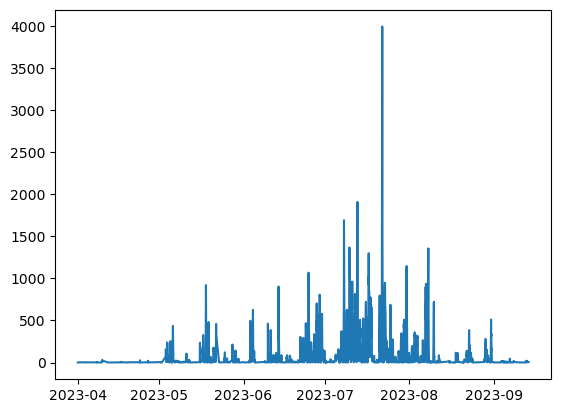

In [294]:
plt.plot(myfr[myfr.prov_name_en == 'British Columbia'].t_agg.astype("datetime64[ns]"), myfr[myfr.prov_name_en == 'British Columbia'].InterCloud)
plt.plot()

NameError: name 'ax2' is not defined

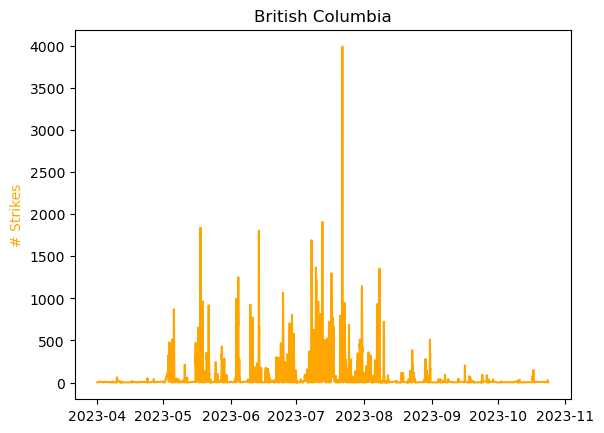

In [10]:
fire_stats.t = fire_stats.t.astype("datetime64[ns]").dt.tz_localize("UTC")

place = 'British Columbia'

fig, ax = plt.subplots()

ax.plot(myfr[myfr.prov_name_en == place].t_agg.astype("datetime64[ns]"), myfr[myfr.prov_name_en == place].InterCloud, 
        color = "orange",
        label= "Lightning")
ax.set_ylabel("# Strikes", color = "orange")
ax.set_title(place)
#ax.legend()
ax2.set_xlim(min(date_range), max(date_range))
ax2 = ax.twinx()
ax2.plot(fire_stats[fire_stats.prov_name_en == place].t, (fire_stats[fire_stats.prov_name_en == place].igs), color = "red", label = "Ignitions")
#ax2.legend()
ax2.set_ylabel("# Ignitions", color = "red")
ax2.set_xlim(min(date_range), max(date_range))
fig.autofmt_xdate()

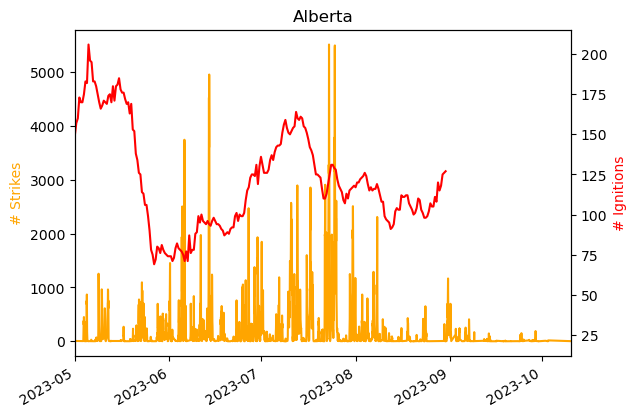

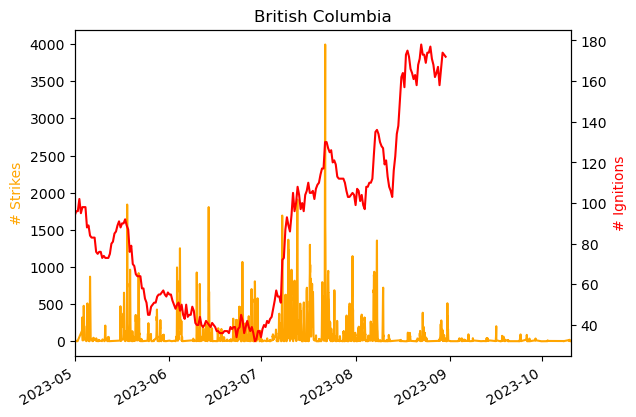

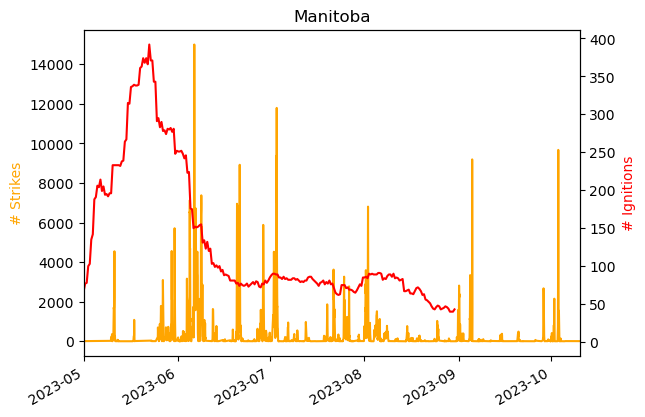

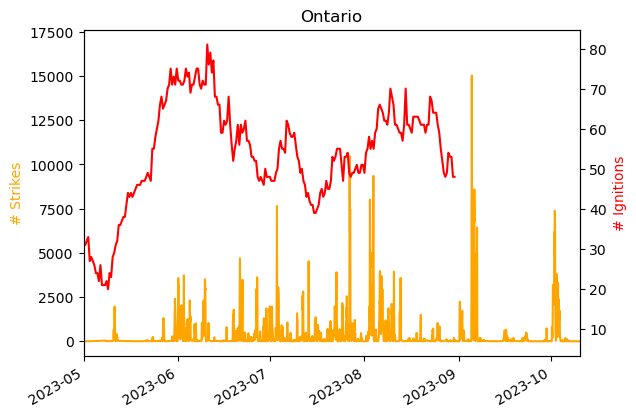

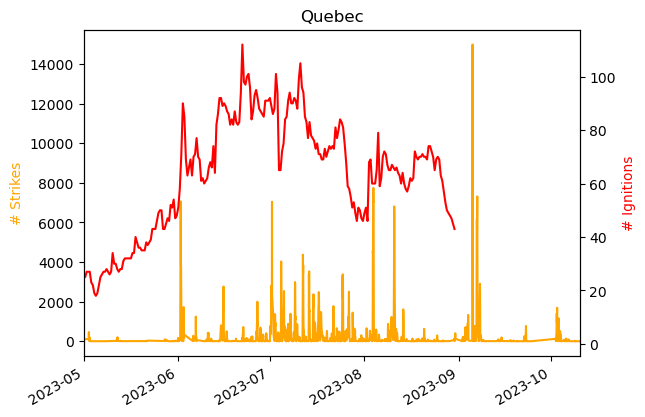

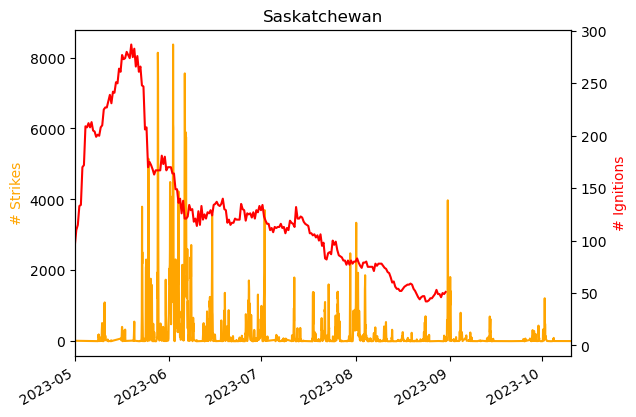

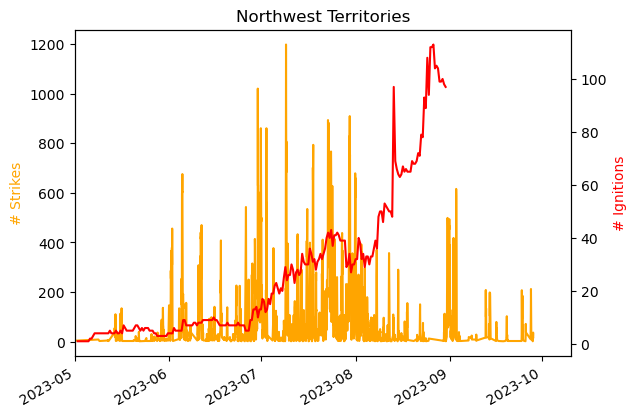

In [18]:
places = fire_stats.prov_name_en.unique()

for place in places:
    if(max(fire_stats[fire_stats.prov_name_en == place].igs) <= 50):
        continue
    fig, ax = plt.subplots()
    ax.plot(myfr[myfr.prov_name_en == place].t_agg.astype("datetime64[ns]"), myfr[myfr.prov_name_en == place].InterCloud, 
            color = "orange",
            label= "Lightning")
    ax.set_ylabel("# Strikes", color = "orange")
    ax.set_title(place)
    #ax.legend(loc = 0)
    ax2 = ax.twinx()
    ax2.set_xlim(min(date_range), max(date_range))
    ax2.plot(fire_stats[fire_stats.prov_name_en == place].t, (fire_stats[fire_stats.prov_name_en == place].igs), color = "red", label = "Ignitions")
    #ax2.legend()
    ax2.set_ylabel("# Ignitions", color = "red")
    ax2.set_xlim(min(date_range), max(date_range))
    fig.autofmt_xdate()
    

In [19]:
fire_stats.columns

Index(['Unnamed: 0', 'prov_name_en', 't', 'farea', 'numfires',
       'num_active_fires', 'tot_frp', 'mean_frp', 'igs', 'num_active_pixels',
       'fireID'],
      dtype='object')

/tmp/ipykernel_220/897404018.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


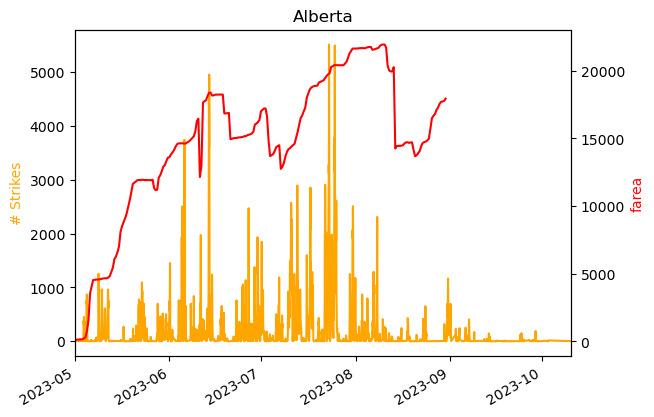

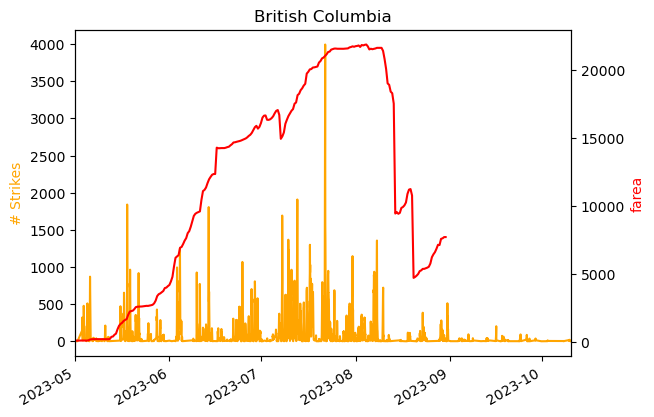

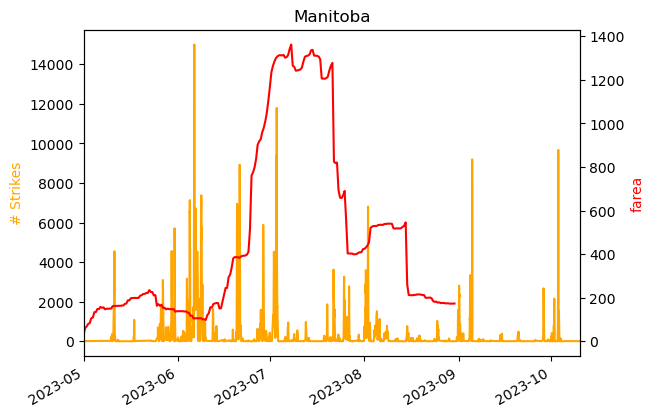

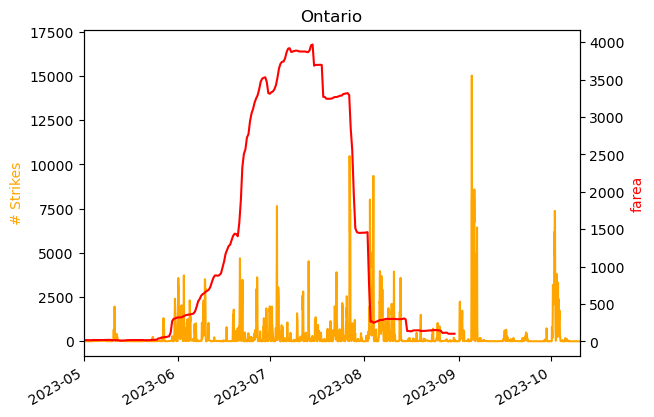

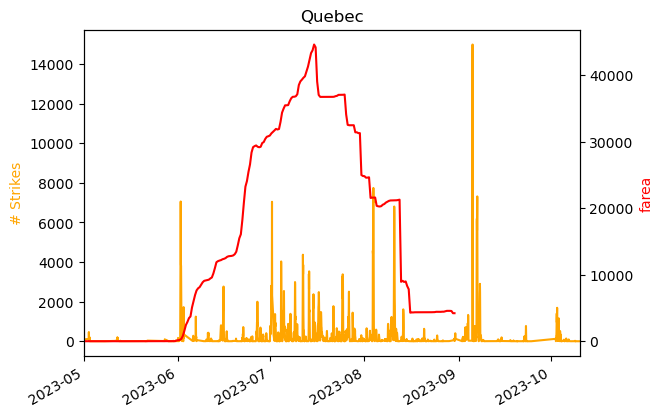

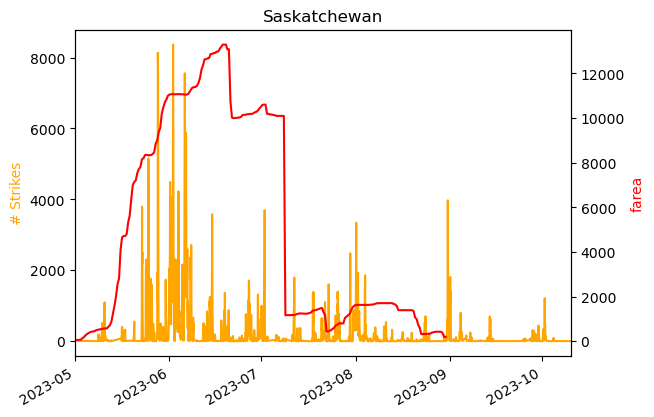

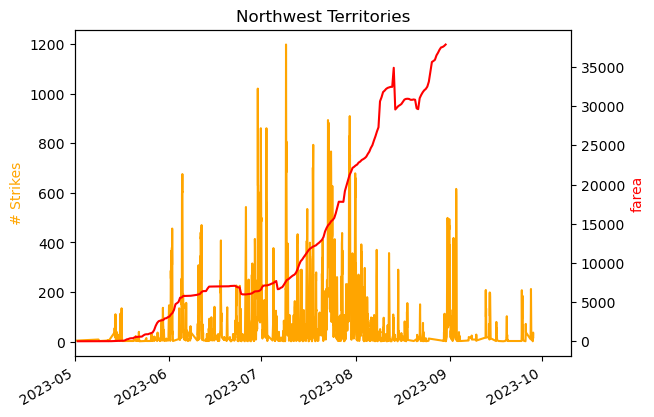

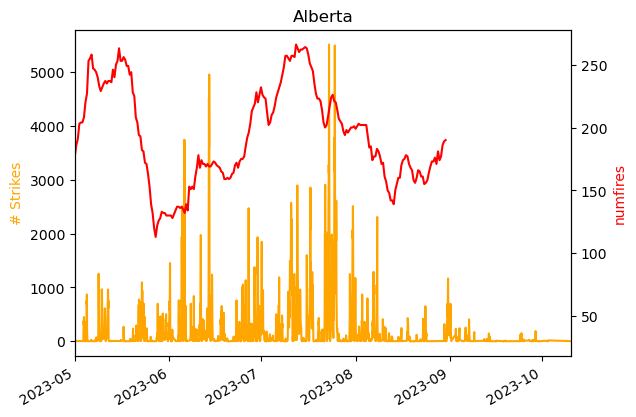

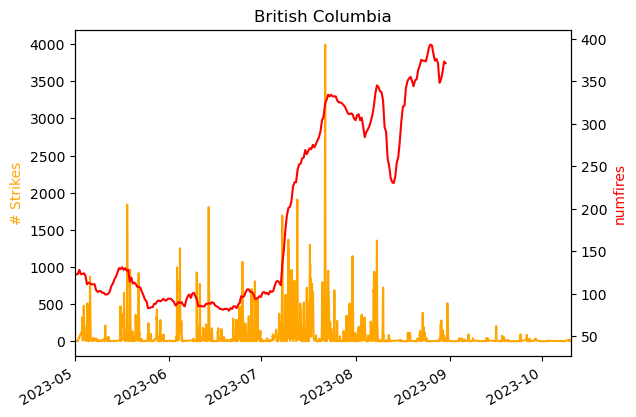

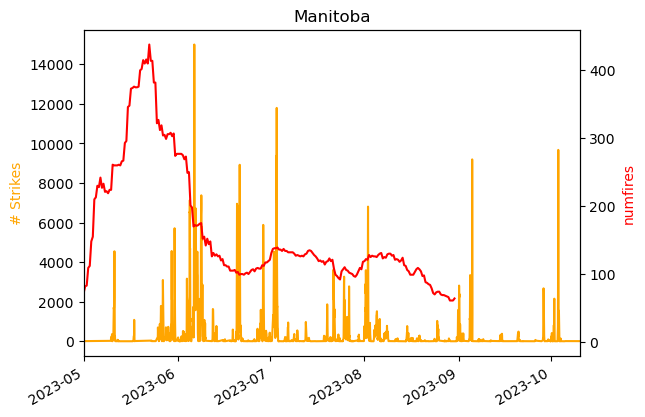

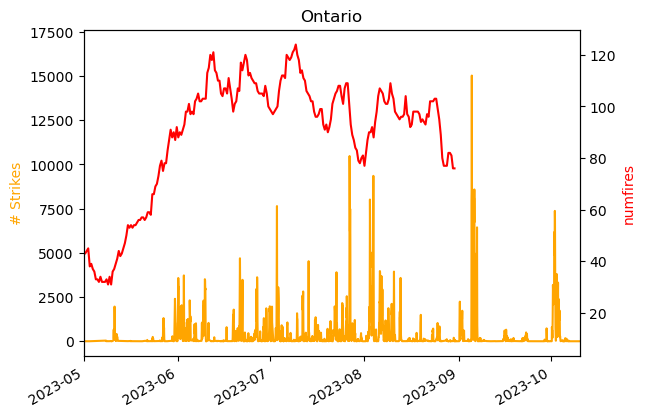

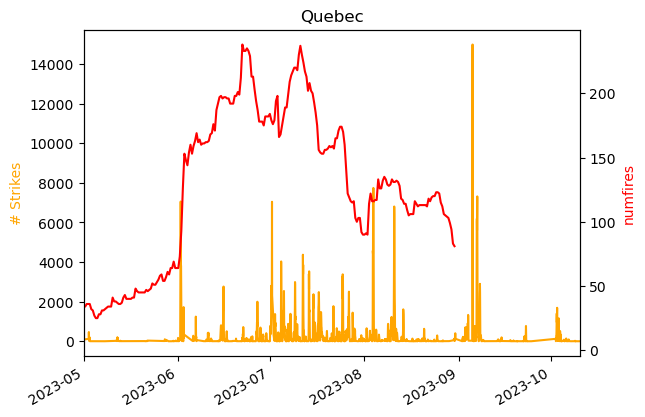

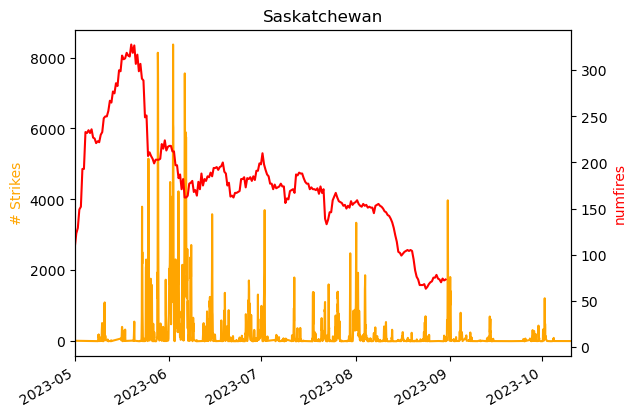

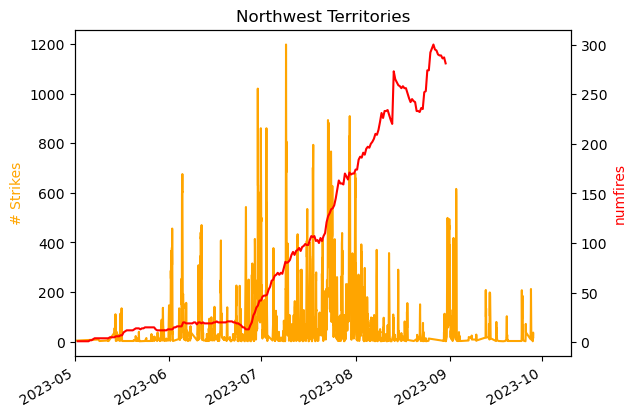

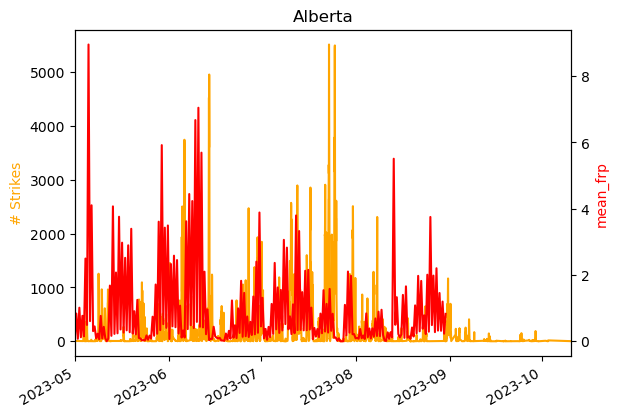

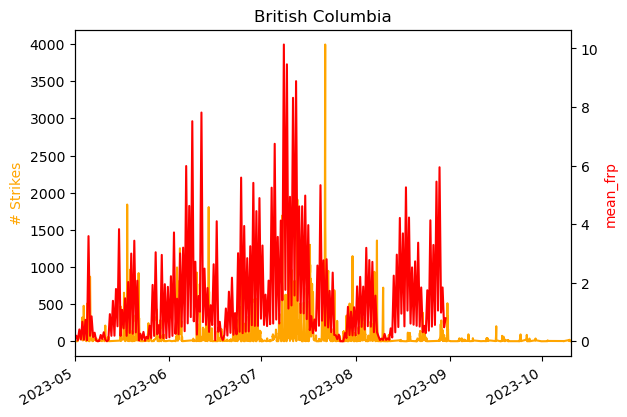

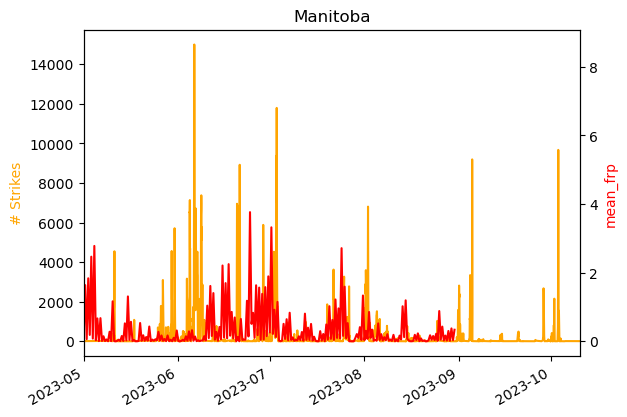

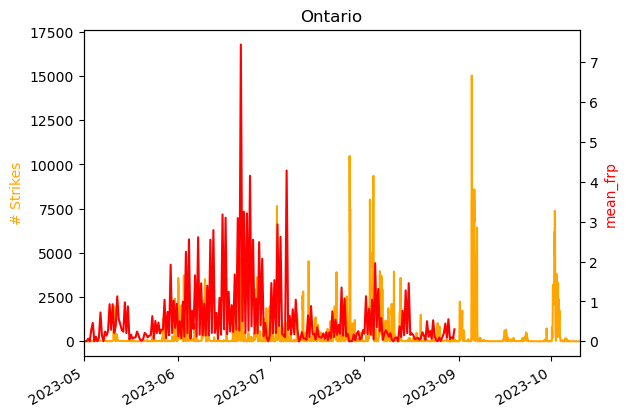

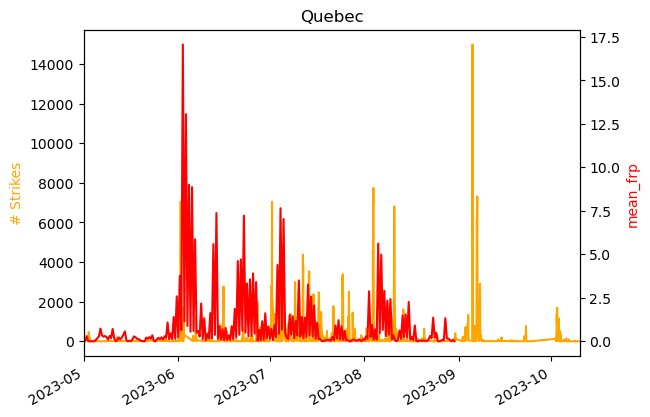

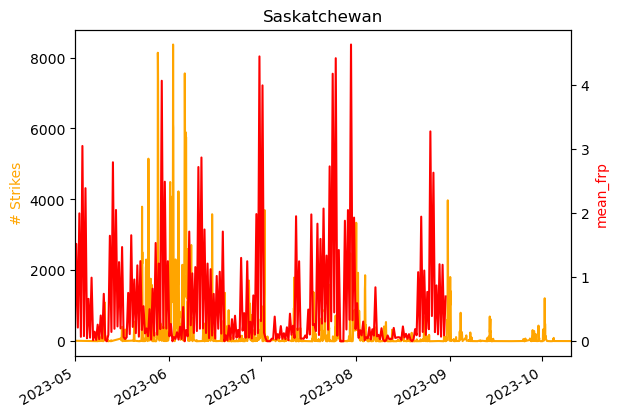

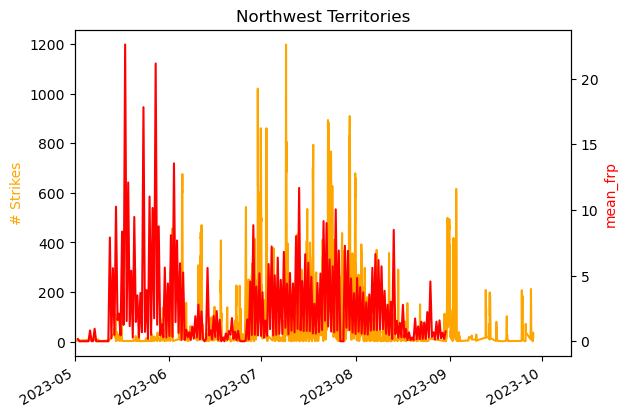

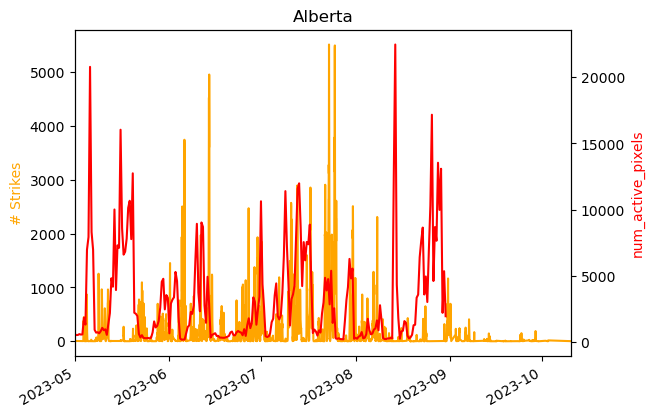

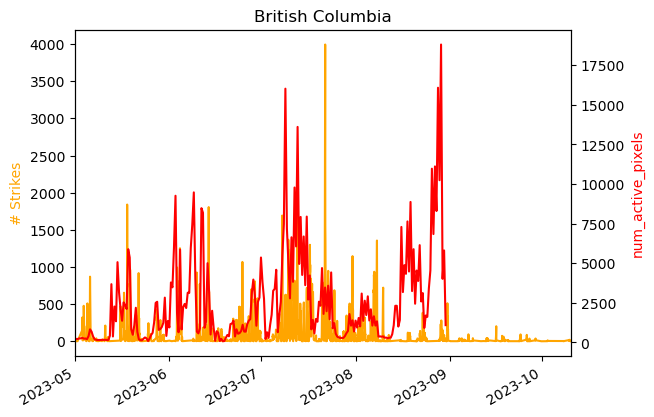

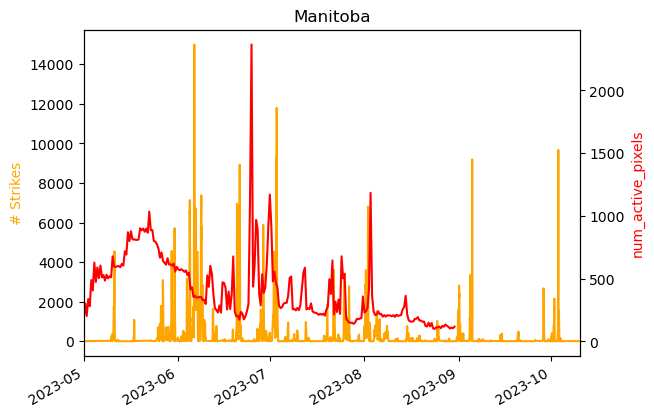

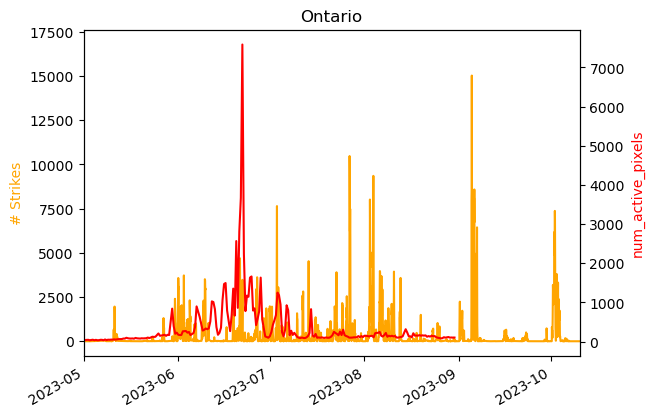

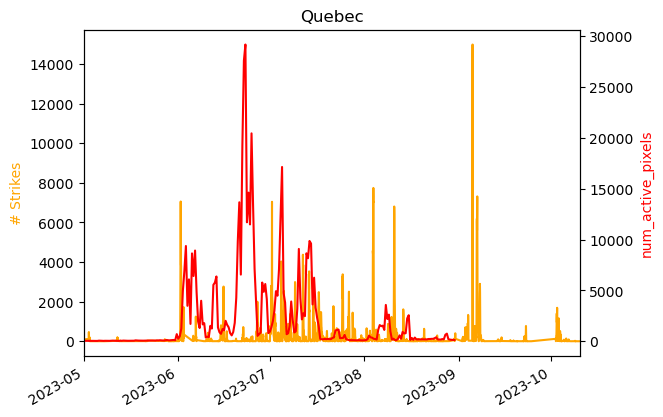

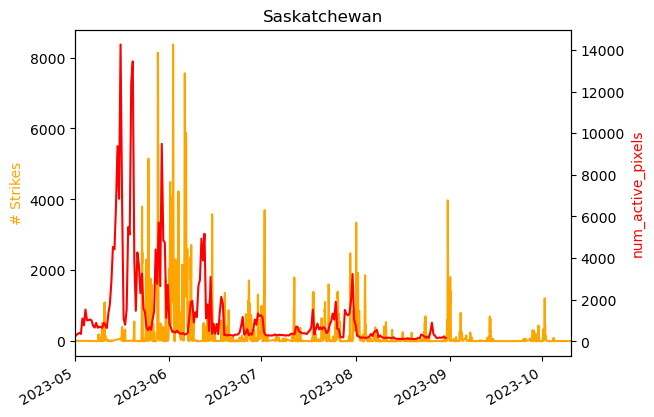

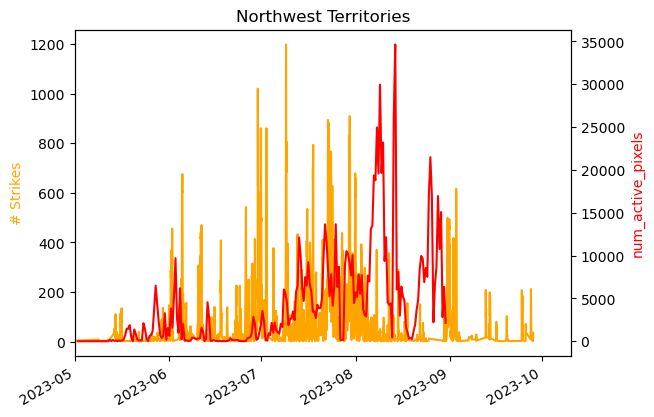

In [25]:
variables = ['farea', 'numfires', 'mean_frp', 'num_active_pixels']

for v in variables:
    for place in places:
        if(max(fire_stats[fire_stats.prov_name_en == place].igs) <= 50):
            continue
        fig, ax = plt.subplots()
        ax.plot(myfr[myfr.prov_name_en == place].t_agg.astype("datetime64[ns]"), myfr[myfr.prov_name_en == place].InterCloud, 
                color = "orange",
                label= "Lightning")
        ax.set_ylabel("# Strikes", color = "orange")
        ax.set_title(place)
        #ax.legend(loc = 0)
        ax2 = ax.twinx()
        ax2.set_xlim(min(date_range), max(date_range))
        ax2.plot(fire_stats[fire_stats.prov_name_en == place].t, (fire_stats[fire_stats.prov_name_en == place][v]), color = "red", label = v)
        #ax2.legend()
        ax2.set_ylabel(v, color = "red")
        ax2.set_xlim(min(date_range), max(date_range))
        fig.autofmt_xdate()